In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
import joblib
import os
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import skew, kurtosis


In [ ]:
from google.colab import files
uploaded = files.upload()

# Load the first file
filename = next(iter(uploaded))
df = pd.read_csv(filename)
print(df.head())

# Calculate sampling rate
time_diffs = np.diff(df['Time (s)'])
sampling_rate = int(round(1 / np.median(time_diffs)))
samples_per_window = sampling_rate
num_windows = len(df) // samples_per_window

segments = []
for i in range(num_windows):
    start = i * samples_per_window
    end = start + samples_per_window
    segment = {
        'start_time': df['Time (s)'].iloc[start],
        'X': df['X-Axis (m/s2)'].iloc[start:end].values,
        'Y': df['Y- Axis (m/s2)'].iloc[start:end].values,
        'Z': df['Z-Axis (m/s2)'].iloc[start:end].values
    }
    segments.append(segment)

def extract_features(segment, fs):
    features = {}
    for axis in ['X', 'Y', 'Z']:
        sig = segment[axis]
        features['rms'] = np.sqrt(np.mean(sig**2))
        features['std'] = np.std(sig)
        features['peak_to_peak'] = np.ptp(sig)
        features['time_skew'] = skew(sig)
        features['time_kurtosis'] = pd.Series(sig).kurtosis()




        freqs, psd = welch(sig, fs=fs)
        band_mask = (freqs >= 50) & (freqs <= 200)
        band_energy = np.sum(psd[band_mask])
        total_energy = np.sum(psd)

        features['band_energy_ratio'] = band_energy / total_energy if total_energy > 0 else 0
        features['dominant_freq'] = freqs[np.argmax(psd)]
        features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd)
        features['peak_count'] = np.sum(psd > np.mean(psd))
        features['spectral_kurtosis'] = kurtosis(psd)

    return features

features_list = [extract_features(seg, sampling_rate) for seg in segments]
features_df = pd.DataFrame(features_list)

# Upload and load model
from google.colab import files
uploaded_model = files.upload()
model = joblib.load(next(iter(uploaded_model)))

# Predict without scaling
features_df['prediction'] = model.predict(features_df)

def interactive_plot(index):
    seg = segments[index]
    label = features_df.iloc[index]['prediction']

    fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    axes = ['X', 'Y', 'Z']
    for i, axis in enumerate(axes):
        sig = seg[axis]
        time = np.linspace(0, 1, len(sig))
        freqs, psd = welch(sig, fs=sampling_rate)

        axs[i, 0].plot(time, sig)
        axs[i, 0].set_title(f"{axis}-axis Time Signal")

        axs[i, 1].semilogy(freqs, psd)
        axs[i, 1].set_title(f"{axis}-axis FFT Spectrum")

    plt.suptitle(f"Segment {index} — {'Chatter' if label else 'Stable'}", fontsize=14)
    plt.tight_layout()
    plt.show()

segment_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(segments) - 1,
    step=1,
    description='Segment:',
    continuous_update=False
)

widgets.interact(interactive_plot, index=segment_slider)



Saving a1_cleaned.csv to a1_cleaned.csv
   Time (s)  X-Axis (m/s2)  Y- Axis (m/s2)  Z-Axis (m/s2)
0  0.000000       0.016907        0.047448      -0.017904
1  0.002470       0.009565        0.001118       0.092957
2  0.004943      -0.111627       -0.048665      -0.116914
3  0.007416       0.117938        0.051428      -0.090291
4  0.009891       0.048750        0.085182       0.029407


Saving voting_model.pkl to voting_model.pkl


interactive(children=(IntSlider(value=0, continuous_update=False, description='Segment:', max=13), Output()), …

<function __main__.interactive_plot(index)>

In [ ]:
Define input and output file paths
input_path = "/content/a1.csv"
output_path = "/content/a1_cleaned.csv"

Open original file and cleaned output file
with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
   for line in infile:
        Remove trailing comma (and whitespace) and write to new file
       cleaned_line = line.rstrip(',\n') + '\n'
       outfile.write(cleaned_line)

print(f"Trailing commas removed. Cleaned file saved to: {output_path}")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import joblib
import ipywidgets as widgets
from sklearn.cluster import KMeans

# =======================
# 1. Upload and load file
# =======================
from google.colab import files
uploaded = files.upload()

filename = next(iter(uploaded))
df = pd.read_csv(filename)
print(df.head())

# =======================
# 2. Segment into 1-sec windows
# =======================
time_diffs = np.diff(df['Time (s)'])
sampling_rate = int(round(1 / np.median(time_diffs)))
samples_per_window = sampling_rate
num_windows = len(df) // samples_per_window

segments = []
for i in range(num_windows):
    start = i * samples_per_window
    end = start + samples_per_window
    segment = {
        'start_time': df['Time (s)'].iloc[start],
        'X': df['X-Axis (m/s2)'].iloc[start:end].values,
        'Y': df['Y- Axis (m/s2)'].iloc[start:end].values,
        'Z': df['Z-Axis (m/s2)'].iloc[start:end].values
    }
    segments.append(segment)

# =======================
# 3. Feature extraction
# =======================
def extract_features(segment, fs):
    features = {}
    for axis in ['X', 'Y', 'Z']:
        sig = segment[axis]

        # --- Time-domain features ---
        features[f'{axis}_rms'] = np.sqrt(np.mean(sig**2))
        features[f'{axis}_std'] = np.std(sig)
        features[f'{axis}_peak_to_peak'] = np.ptp(sig)
        features[f'{axis}_skew'] = skew(sig)
        features[f'{axis}_kurtosis'] = pd.Series(sig).kurtosis()

        # --- Frequency-domain features ---
        freqs, psd = welch(sig, fs=fs)
        band_mask = (freqs >= 50) & (freqs <= 200)
        band_energy = np.sum(psd[band_mask])
        total_energy = np.sum(psd)

        features[f'{axis}_band_energy_ratio'] = band_energy / total_energy if total_energy > 0 else 0
        features[f'{axis}_dominant_freq'] = freqs[np.argmax(psd)]
        features[f'{axis}_spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd)
        features[f'{axis}_peak_count'] = np.sum(psd > np.mean(psd))
        features[f'{axis}_spectral_kurtosis'] = kurtosis(psd)

    return features

features_list = [extract_features(seg, sampling_rate) for seg in segments]
features_df = pd.DataFrame(features_list)

# =======================
# 4. Load trained model
# =======================
uploaded_model = files.upload()
model = joblib.load(next(iter(uploaded_model)))

# Predict without scaling (⚠️ if you used a scaler in training, load & apply it here)
features_df['prediction'] = model.predict(features_df)

# =======================
# 5. Interactive plotting
# =======================
def interactive_plot(index):
    seg = segments[index]
    label = features_df.iloc[index]['prediction']

    fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    axes = ['X', 'Y', 'Z']
    for i, axis in enumerate(axes):
        sig = seg[axis]
        time = np.linspace(0, 1, len(sig))
        freqs, psd = welch(sig, fs=sampling_rate)

        axs[i, 0].plot(time, sig)
        axs[i, 0].set_title(f"{axis}-axis Time Signal")

        axs[i, 1].semilogy(freqs, psd)
        axs[i, 1].set_title(f"{axis}-axis FFT Spectrum")

    plt.suptitle(f"Segment {index} — {'Chatter' if label else 'Stable'}", fontsize=14)
    plt.tight_layout()
    plt.show()

segment_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(segments) - 1,
    step=1,
    description='Segment:',
    continuous_update=False
)
widgets.interact(interactive_plot, index=segment_slider);

# =======================
# 6. Unsupervised KMeans check
# =======================
kmeans = KMeans(n_clusters=2, random_state=42)
features_df['cluster'] = kmeans.fit_predict(features_df.drop(columns=['prediction']))

print("\n=== Cluster vs Prediction Crosstab ===")
print(pd.crosstab(features_df['cluster'], features_df['prediction']))

# Visualization: counts of predictions per cluster
plt.figure(figsize=(6,4))
sns.countplot(x='cluster', hue='prediction', data=features_df, palette="Set2")
plt.title("Model Predictions vs KMeans Clusters")
plt.xlabel("Cluster (unsupervised)")
plt.ylabel("Count")
plt.legend(title="Prediction", labels=['Stable (0)', 'Chatter (1)'])
plt.show()

# =======================
# 7. KDE of dominant frequency per cluster
# =======================
plt.figure(figsize=(6,4))
sns.kdeplot(features_df['X_dominant_freq'], hue=features_df['cluster'], fill=True, common_norm=False, palette="Set1")
plt.title("KDE of Dominant Frequency (X-axis) per Cluster")
plt.xlabel("Dominant Frequency (Hz)")
plt.ylabel("Density")
plt.show()


Saving A14.csv to A14.csv
          Time (s)  X-Axis (m/s2)  Y- Axis (m/s2)  Z-Axis (m/s2)
0.000000 -0.024962      -0.009538       -0.035081            NaN
0.002476 -0.062330       0.077089       -0.035985            NaN
0.004946  0.022856      -0.071048        0.249612            NaN
0.007419 -0.020115       0.088721        0.051609            NaN
0.009892  0.083148       0.061377       -0.019432            NaN


KeyboardInterrupt: 

Saving A14.csv to A14 (6).csv
✅ Trailing commas removed. Cleaned file saved to: /content/cleaned_input.csv
   Time (s)  X-Axis (m/s2)  Y- Axis (m/s2)  Z-Axis (m/s2)
0  0.000000      -0.024962       -0.009538      -0.035081
1  0.002476      -0.062330        0.077089      -0.035985
2  0.004946       0.022856       -0.071048       0.249612
3  0.007419      -0.020115        0.088721       0.051609
4  0.009892       0.083148        0.061377      -0.019432


Saving voting_model.pkl to voting_model (7).pkl


interactive(children=(IntSlider(value=0, continuous_update=False, description='Segment:', max=15), Output()), …


=== Cluster vs Prediction Crosstab ===
prediction  0  1
cluster         
0           8  0
1           6  2


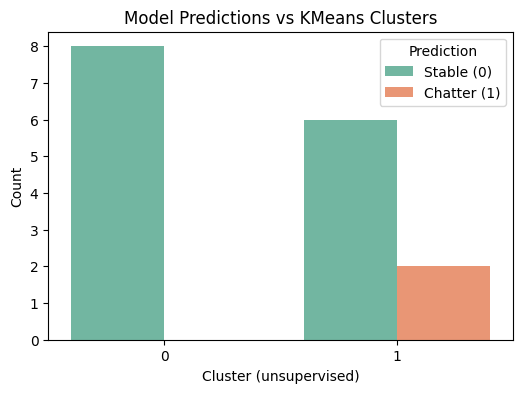

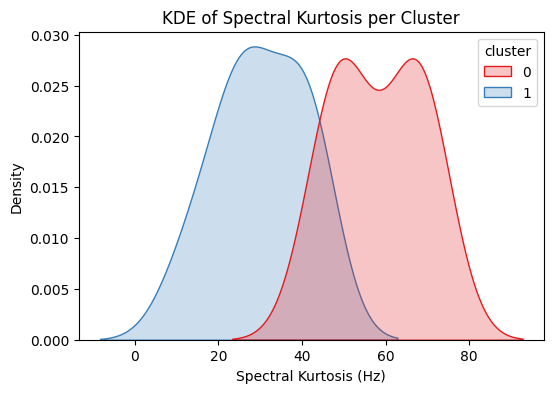

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import joblib
import ipywidgets as widgets
from sklearn.cluster import KMeans

# =======================
# 0. Upload and clean file (remove trailing commas)
# =======================
from google.colab import files
uploaded = files.upload()

# Define input and output paths
input_path = next(iter(uploaded))
output_path = "/content/cleaned_input.csv"

# Clean the file
with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
    for line in infile:
        cleaned_line = line.rstrip(',\n') + '\n'
        outfile.write(cleaned_line)

print(f"✅ Trailing commas removed. Cleaned file saved to: {output_path}")

# =======================
# 1. Load cleaned file
# =======================
df = pd.read_csv(output_path)
print(df.head())

# =======================
# 2. Segment into 1-sec windows
# =======================
time_diffs = np.diff(df['Time (s)'])
sampling_rate = int(round(1 / np.median(time_diffs)))
samples_per_window = sampling_rate
num_windows = len(df) // samples_per_window

segments = []
for i in range(num_windows):
    start = i * samples_per_window
    end = start + samples_per_window
    segment = {
        'start_time': df['Time (s)'].iloc[start],
        'X': df['X-Axis (m/s2)'].iloc[start:end].values,
        'Y': df['Y- Axis (m/s2)'].iloc[start:end].values,
        'Z': df['Z-Axis (m/s2)'].iloc[start:end].values
    }
    segments.append(segment)

# =======================
# 3. Feature extraction
# =======================
def extract_features(segment, fs):
    features = {}
    for axis in ['X', 'Y', 'Z']:
        sig = segment[axis]

        # --- Time-domain features ---
        features['rms'] = np.sqrt(np.mean(sig**2))
        features['std'] = np.std(sig)
        features['peak_to_peak'] = np.ptp(sig)
        features['time_skew'] = skew(sig)
        features['time_kurtosis'] = pd.Series(sig).kurtosis()

        # --- Frequency-domain features ---
        freqs, psd = welch(sig, fs=fs)
        band_mask = (freqs >= 50) & (freqs <= 200)
        band_energy = np.sum(psd[band_mask])
        total_energy = np.sum(psd)

        features['band_energy_ratio'] = band_energy / total_energy if total_energy > 0 else 0
        features['dominant_freq'] = freqs[np.argmax(psd)]
        features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd)
        features['peak_count'] = np.sum(psd > np.mean(psd))
        features['spectral_kurtosis'] = kurtosis(psd)

    return features

features_list = [extract_features(seg, sampling_rate) for seg in segments]
features_df = pd.DataFrame(features_list)

# =======================
# 4. Load trained model
# =======================
uploaded_model = files.upload()
model = joblib.load(next(iter(uploaded_model)))

# Predict (⚠️ apply scaler here if used during training)
features_df['prediction'] = model.predict(features_df)

# =======================
# 5. Interactive plotting
# =======================
def interactive_plot(index):
    seg = segments[index]
    label = features_df.iloc[index]['prediction']

    fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    axes = ['X', 'Y', 'Z']
    for i, axis in enumerate(axes):
        sig = seg[axis]
        time = np.linspace(0, 1, len(sig))
        freqs, psd = welch(sig, fs=sampling_rate)

        axs[i, 0].plot(time, sig)
        axs[i, 0].set_title(f"{axis}-axis Time Signal")

        axs[i, 1].semilogy(freqs, psd)
        axs[i, 1].set_title(f"{axis}-axis FFT Spectrum")

    plt.suptitle(f"Segment {index} — {'Chatter' if label else 'Stable'}", fontsize=14)
    plt.tight_layout()
    plt.show()

segment_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(segments) - 1,
    step=1,
    description='Segment:',
    continuous_update=False
)
widgets.interact(interactive_plot, index=segment_slider);

# =======================
# 6. Unsupervised KMeans check
# =======================
kmeans = KMeans(n_clusters=2, random_state=42)
features_df['cluster'] = kmeans.fit_predict(features_df.drop(columns=['prediction']))

print("\n=== Cluster vs Prediction Crosstab ===")
print(pd.crosstab(features_df['cluster'], features_df['prediction']))

# Visualization: counts of predictions per cluster
plt.figure(figsize=(6,4))
sns.countplot(x='cluster', hue='prediction', data=features_df, palette="Set2")
plt.title("Model Predictions vs KMeans Clusters")
plt.xlabel("Cluster (unsupervised)")
plt.ylabel("Count")
plt.legend(title="Prediction", labels=['Stable (0)', 'Chatter (1)'])
plt.show()

# =======================
# 7. KDE of dominant frequency per cluster
# =======================
plt.figure(figsize=(6,4))
sns.kdeplot(
    data=features_df,
    x='spectral_kurtosis',
    hue='cluster',
    fill=True,
    common_norm=False,
    palette="Set1"
)
plt.title("KDE of Spectral Kurtosis per Cluster")
plt.xlabel("Spectral Kurtosis (Hz)")
plt.show()


Saving A10.csv to A10.csv
✅ Trailing commas removed. Cleaned file saved to: /content/cleaned_input.csv
   Time (s)  X-Axis (m/s2)  Y- Axis (m/s2)  Z-Axis (m/s2)
0  0.000000      -0.197619        0.003162       0.074165
1  0.002473       0.070745       -0.096711       0.292972
2  0.004948      -0.038684        0.006632       0.072018
3  0.007419       0.141133        0.091705       0.126374
4  0.009891      -0.115934       -0.045796      -0.170941


Saving voting_model.pkl to voting_model (9).pkl


interactive(children=(IntSlider(value=0, continuous_update=False, description='Segment:', max=17), Output()), …


=== Cluster vs Prediction Crosstab ===
prediction  0   1
cluster          
0           7  10
1           0   1


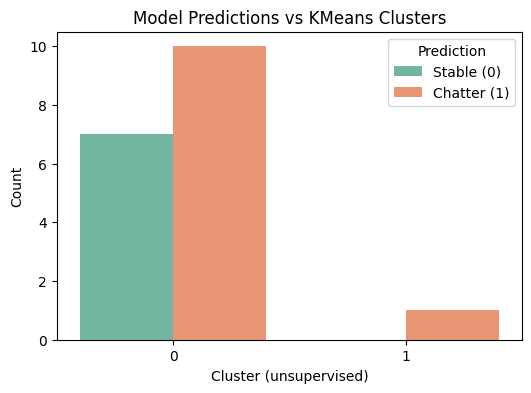


✅ Model predictions match cluster labels: 61.11%


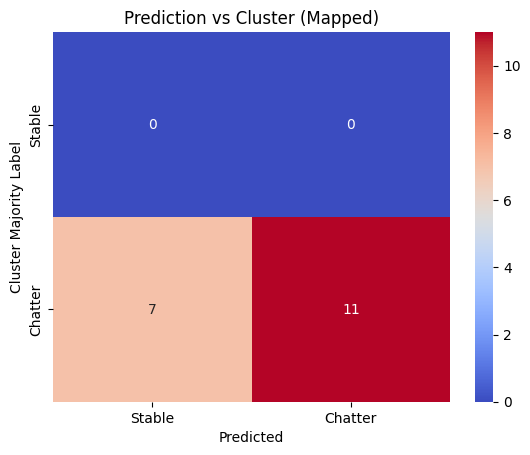

/tmp/ipython-input-235409875.py:178: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


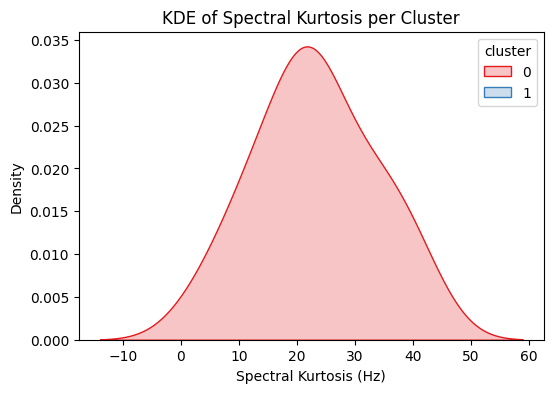

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import joblib
import ipywidgets as widgets
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

# =======================
# 0. Upload and clean file (remove trailing commas)
# =======================
from google.colab import files
uploaded = files.upload()

# Define input and output paths
input_path = next(iter(uploaded))
output_path = "/content/cleaned_input.csv"

# Clean the file
with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
    for line in infile:
        cleaned_line = line.rstrip(',\n') + '\n'
        outfile.write(cleaned_line)

print(f"✅ Trailing commas removed. Cleaned file saved to: {output_path}")

# =======================
# 1. Load cleaned file
# =======================
df = pd.read_csv(output_path)
print(df.head())

# =======================
# 2. Segment into 1-sec windows
# =======================
time_diffs = np.diff(df['Time (s)'])
sampling_rate = int(round(1 / np.median(time_diffs)))
samples_per_window = sampling_rate
num_windows = len(df) // samples_per_window

segments = []
for i in range(num_windows):
    start = i * samples_per_window
    end = start + samples_per_window
    segment = {
        'start_time': df['Time (s)'].iloc[start],
        'X': df['X-Axis (m/s2)'].iloc[start:end].values,
        'Y': df['Y- Axis (m/s2)'].iloc[start:end].values,
        'Z': df['Z-Axis (m/s2)'].iloc[start:end].values
    }
    segments.append(segment)

# =======================
# 3. Feature extraction
# =======================
def extract_features(segment, fs):
    features = {}
    for axis in ['X', 'Y', 'Z']:
        sig = segment[axis]

        # --- Time-domain features ---
        features['rms'] = np.sqrt(np.mean(sig**2))
        features['std'] = np.std(sig)
        features['peak_to_peak'] = np.ptp(sig)
        features['time_skew'] = skew(sig)
        features['time_kurtosis'] = pd.Series(sig).kurtosis()

        # --- Frequency-domain features ---
        freqs, psd = welch(sig, fs=fs)
        band_mask = (freqs >= 50) & (freqs <= 200)
        band_energy = np.sum(psd[band_mask])
        total_energy = np.sum(psd)

        features['band_energy_ratio'] = band_energy / total_energy if total_energy > 0 else 0
        features['dominant_freq'] = freqs[np.argmax(psd)]
        features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd)
        features['peak_count'] = np.sum(psd > np.mean(psd))
        features['spectral_kurtosis'] = kurtosis(psd)

    return features

features_list = [extract_features(seg, sampling_rate) for seg in segments]
features_df = pd.DataFrame(features_list)

# =======================
# 4. Load trained model
# =======================
uploaded_model = files.upload()
model = joblib.load(next(iter(uploaded_model)))

# Predict (⚠️ apply scaler here if used during training)
features_df['prediction'] = model.predict(features_df)

# =======================
# 5. Interactive plotting
# =======================
def interactive_plot(index):
    seg = segments[index]
    label = features_df.iloc[index]['prediction']

    fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    axes = ['X', 'Y', 'Z']
    for i, axis in enumerate(axes):
        sig = seg[axis]
        time = np.linspace(0, 1, len(sig))
        freqs, psd = welch(sig, fs=sampling_rate)

        axs[i, 0].plot(time, sig)
        axs[i, 0].set_title(f"{axis}-axis Time Signal")

        axs[i, 1].semilogy(freqs, psd)
        axs[i, 1].set_title(f"{axis}-axis FFT Spectrum")

    plt.suptitle(f"Segment {index} — {'Chatter' if label else 'Stable'}", fontsize=14)
    plt.tight_layout()
    plt.show()

segment_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(segments) - 1,
    step=1,
    description='Segment:',
    continuous_update=False
)
widgets.interact(interactive_plot, index=segment_slider);

# =======================
# 6. Unsupervised KMeans check
# =======================
kmeans = KMeans(n_clusters=2, random_state=42)
features_df['cluster'] = kmeans.fit_predict(features_df.drop(columns=['prediction']))

print("\n=== Cluster vs Prediction Crosstab ===")
print(pd.crosstab(features_df['cluster'], features_df['prediction']))

plt.figure(figsize=(6,4))
sns.countplot(x='cluster', hue='prediction', data=features_df, palette="Set2")
plt.title("Model Predictions vs KMeans Clusters")
plt.xlabel("Cluster (unsupervised)")
plt.ylabel("Count")
plt.legend(title="Prediction", labels=['Stable (0)', 'Chatter (1)'])
plt.show()

# =======================
# 6b. Accuracy of Predictions vs Clusters
# =======================
# Map each cluster to its majority prediction
cluster_to_label = {}
for cluster in features_df['cluster'].unique():
    majority_label = features_df[features_df['cluster'] == cluster]['prediction'].mode()[0]
    cluster_to_label[cluster] = majority_label

# Map clusters to aligned labels
features_df['cluster_mapped'] = features_df['cluster'].map(cluster_to_label)

# Agreement percentage
agreement = np.mean(features_df['cluster_mapped'] == features_df['prediction'])
print(f"\n✅ Model predictions match cluster labels: {agreement*100:.2f}%")

# Confusion matrix heatmap
cm = confusion_matrix(features_df['cluster_mapped'], features_df['prediction'])
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Stable', 'Chatter'],
            yticklabels=['Stable', 'Chatter'])
plt.title("Prediction vs Cluster (Mapped)")
plt.xlabel("Predicted")
plt.ylabel("Cluster Majority Label")
plt.show()

# =======================
# 7. KDE of dominant frequency per cluster
# =======================
plt.figure(figsize=(6,4))
sns.kdeplot(
    data=features_df,
    x='spectral_kurtosis',
    hue='cluster',
    fill=True,
    common_norm=False,
    palette="Set1"
)
plt.title("KDE of Spectral Kurtosis per Cluster")
plt.xlabel("Spectral Kurtosis (Hz)")
plt.show()


Saving data.zip to data (2).zip
✅ Extracted all CSVs to /content/csv_folder
✅ Total segmented windows across all files: 621


Saving voting_model.pkl to voting_model (13).pkl

✅ Overall model predictions match cluster labels: 94.85%

=== Agreement per file ===
A4.csv: 100.00%
A16.csv: 90.32%
A10.csv: 61.11%
A13.csv: 80.00%
A11.csv: 100.00%
A9.csv: 96.30%
A8.csv: 94.12%
A3.csv: 98.62%
A12.csv: 97.56%
A15.csv: 100.00%
A5.csv: 96.34%
A7.csv: 80.95%
A1.csv: 100.00%


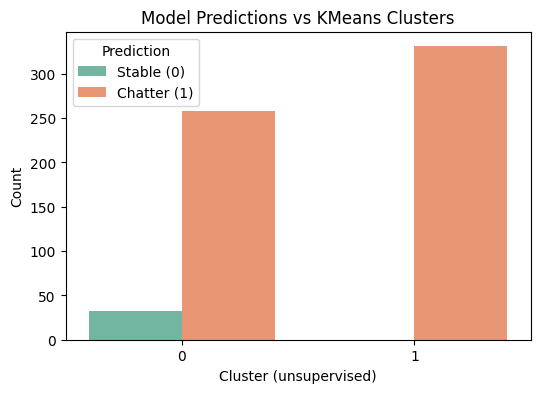

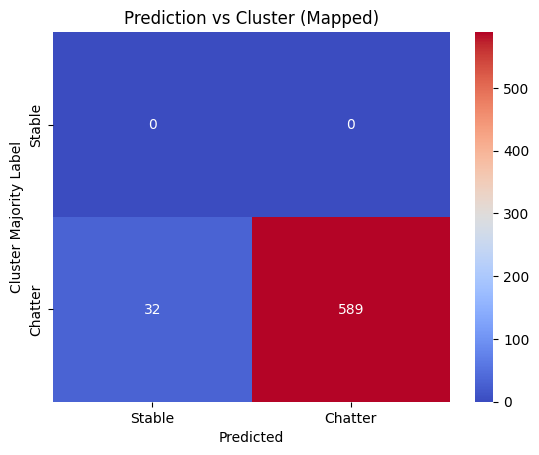

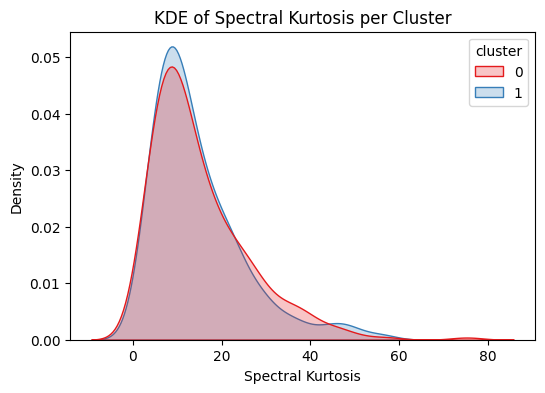

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, zipfile, shutil
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import joblib
from google.colab import files

# =======================
# 0. Upload and Extract ZIP (flattened, no subfolder)
# =======================
uploaded = files.upload()
zip_path = next(iter(uploaded))
extract_dir = "/content/csv_folder"

if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
        filename = os.path.basename(member)
        if filename.endswith(".csv"):
            source = zip_ref.open(member)
            target = open(os.path.join(extract_dir, filename), "wb")
            with source, target:
                shutil.copyfileobj(source, target)

print(f"✅ Extracted all CSVs to {extract_dir}")

# =======================
# 1. File cleaning + segmentation
# =======================
def clean_file(input_path, output_path):
    with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
        for line in infile:
            cleaned_line = line.rstrip(',\n') + '\n'
            outfile.write(cleaned_line)

def segment_file(file_path):
    cleaned_path = file_path.replace(".csv", "_cleaned.csv")
    clean_file(file_path, cleaned_path)

    df = pd.read_csv(cleaned_path)
    time_diffs = np.diff(df['Time (s)'])
    sampling_rate = int(round(1 / np.median(time_diffs)))
    samples_per_window = sampling_rate
    num_windows = len(df) // samples_per_window

    segments = []
    for i in range(num_windows):
        start = i * samples_per_window
        end = start + samples_per_window
        segment = {
            'start_time': df['Time (s)'].iloc[start],
            'X': df['X-Axis (m/s2)'].iloc[start:end].values,
            'Y': df['Y- Axis (m/s2)'].iloc[start:end].values,
            'Z': df['Z-Axis (m/s2)'].iloc[start:end].values
        }
        segments.append(segment)

    return segments, sampling_rate

all_segments = []
segment_file_map = []  # Track which file each segment belongs to
for fname in os.listdir(extract_dir):
    if fname.endswith(".csv"):
        file_segments, sampling_rate = segment_file(os.path.join(extract_dir, fname))
        all_segments.extend(file_segments)
        segment_file_map.extend([fname]*len(file_segments))  # keep file mapping

print(f"✅ Total segmented windows across all files: {len(all_segments)}")

# =======================
# 2. Feature extraction (only Z-axis contributes)
# =======================
def extract_features(segment, fs):
    features = {}
    sig = segment['Z']

    # --- Time-domain features ---
    features['rms'] = np.sqrt(np.mean(sig**2))
    features['std'] = np.std(sig)
    features['peak_to_peak'] = np.ptp(sig)
    features['time_skew'] = skew(sig)
    features['time_kurtosis'] = pd.Series(sig).kurtosis()

    # --- Frequency-domain features ---
    freqs, psd = welch(sig, fs=fs)
    band_mask = (freqs >= 50) & (freqs <= 200)
    band_energy = np.sum(psd[band_mask])
    total_energy = np.sum(psd)

    features['band_energy_ratio'] = band_energy / total_energy if total_energy > 0 else 0
    features['dominant_freq'] = freqs[np.argmax(psd)]
    features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd)
    features['peak_count'] = np.sum(psd > np.mean(psd))
    features['spectral_kurtosis'] = kurtosis(psd)

    return features

features_list = [extract_features(seg, sampling_rate) for seg in all_segments]
features_df = pd.DataFrame(features_list)
features_df['file'] = segment_file_map  # add file column

# =======================
# 3. Load trained model and predict
# =======================
uploaded_model = files.upload()
model = joblib.load(next(iter(uploaded_model)))
feature_cols = [col for col in features_df.columns if col not in ['file', 'prediction', 'cluster', 'cluster_mapped']]
features_df['prediction'] = model.predict(features_df[feature_cols])


# =======================
# 4. KMeans clustering + accuracy vs predictions
# =======================
kmeans = KMeans(n_clusters=2, random_state=42)
features_df['cluster'] = kmeans.fit_predict(features_df.drop(columns=['prediction','file']))

# Map each cluster to its majority prediction
cluster_to_label = {}
for cluster in features_df['cluster'].unique():
    majority_label = features_df[features_df['cluster'] == cluster]['prediction'].mode()[0]
    cluster_to_label[cluster] = majority_label

features_df['cluster_mapped'] = features_df['cluster'].map(cluster_to_label)

# Overall agreement
overall_agreement = np.mean(features_df['cluster_mapped'] == features_df['prediction'])
print(f"\n✅ Overall model predictions match cluster labels: {overall_agreement*100:.2f}%")

# =======================
# 4a. Agreement per file
# =======================
print("\n=== Agreement per file ===")
for fname in features_df['file'].unique():
    file_df = features_df[features_df['file'] == fname]
    agreement = np.mean(file_df['cluster_mapped'] == file_df['prediction'])
    print(f"{fname}: {agreement*100:.2f}%")

# =======================
# 5. Cluster vs Prediction plots
# =======================
plt.figure(figsize=(6,4))
sns.countplot(x='cluster', hue='prediction', data=features_df, palette="Set2")
plt.title("Model Predictions vs KMeans Clusters")
plt.xlabel("Cluster (unsupervised)")
plt.ylabel("Count")
plt.legend(title="Prediction", labels=['Stable (0)', 'Chatter (1)'])
plt.show()

cm = confusion_matrix(features_df['cluster_mapped'], features_df['prediction'])
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Stable', 'Chatter'],
            yticklabels=['Stable', 'Chatter'])
plt.title("Prediction vs Cluster (Mapped)")
plt.xlabel("Predicted")
plt.ylabel("Cluster Majority Label")
plt.show()

plt.figure(figsize=(6,4))
sns.kdeplot(
    data=features_df,
    x='spectral_kurtosis',
    hue='cluster',
    fill=True,
    common_norm=False,
    palette="Set1"
)
plt.title("KDE of Spectral Kurtosis per Cluster")
plt.xlabel("Spectral Kurtosis")
plt.show()
